# Model Training

In [23]:
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

In [24]:
import sys, os

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

In [25]:
import pickle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout

from preprocess import filter_data
from utils import train_data
from train import feature_importance, lstm_features, print_evaluation, process_features

import warnings

warnings.filterwarnings("ignore")

## Energy Prediction

### Regressors
- Linear Regression (Baseline)
- Light GBM Regressor
- XGBoost

In [5]:
train_df = train_data()
train_df.shape

(46083, 5)

In [6]:
train_df = filter_data(train_df)

X = train_df.drop(columns=["date_time", "active_power"])
y = train_df["active_power"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
models_dict = {
    "LinearRegression": LinearRegression(),
    "LightGBMRegression": LGBMRegressor(),
    "XGBoostRegression": XGBRegressor(),
}

In [8]:
# wrapping custom function
transform_features = FunctionTransformer(process_features)

for key, classifier in models_dict.items():
    print(f"Model: {key}")
    pipe = make_pipeline(transform_features, classifier)
    # fit the pipeline on the transformed data
    pipe.fit(X_train, y_train)
    # make predictions
    y_pred = pipe.predict(X_test)
    print_evaluation(y_test, y_pred)

Model: LinearRegression
		Error Table
Mean Absolute Error      : 126.43476258204669
Mean Squared  Error      : 60999.25696784553
Root Mean Squared  Error : 246.98027647536054
R2 Score                 : 0.9604384284795526
Mean Absolute Percentage Error: 0.9571878679384092
Model: LightGBMRegression
		Error Table
Mean Absolute Error      : 111.80338109921983
Mean Squared  Error      : 57767.98168379472
Root Mean Squared  Error : 240.34970705993115
R2 Score                 : 0.9625340987320544
Mean Absolute Percentage Error: 1.0358244703259416
Model: XGBoostRegression
		Error Table
Mean Absolute Error      : 126.8187687869468
Mean Squared  Error      : 71356.23534264475
Root Mean Squared  Error : 267.12587920799575
R2 Score                 : 0.9537213246806271
Mean Absolute Percentage Error: 1.057456567018026


The LinearRegression and LightGBM models have similar evaluation results over XGBoost.

### Feature Importances

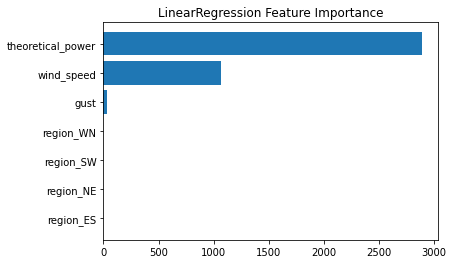

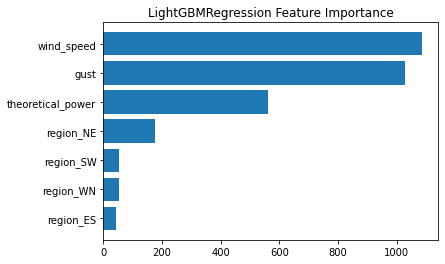

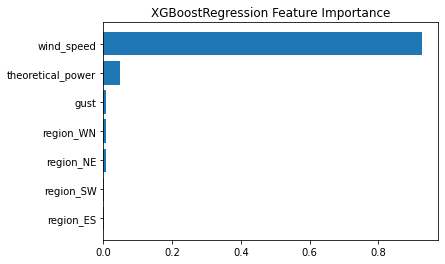

In [26]:
for key, _ in models_dict.items():
    feature_importance(models_dict[key], X_train, key)

### Save Models

In [21]:
for key, model in models_dict.items():
    pickle.dump(model, open(f"../models/wind_{key}.pkl", "wb"))

#### LSTM

In [10]:
def lstm_model():
    # define the layers
    x_in = Input(shape=(1, 8))  # 8 is number of columns after processing
    x1 = LSTM(16, return_sequences=True)(x_in)
    d = Dropout(0.2)(x1)
    x2 = LSTM(8)(d)
    x_out = Dense(1, activation="linear")(x2)  # Regression problem
    # define the model
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])
    return model

In [11]:
# Feature engineering
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = lstm_features()

X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], 1, X_train_lstm.shape[1])
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], 1, X_test_lstm.shape[1])

model_lstm = lstm_model()
model_lstm.fit(
    X_train_lstm, y_train_lstm, epochs=10, batch_size=64, verbose=0, shuffle=False
)

y_pred_lstm = model_lstm.predict(X_test_lstm)
print_evaluation(y_test_lstm, y_pred_lstm)

		Error Table
Mean Absolute Error      : 1655.4369166899078
Mean Squared  Error      : 4325132.90561727
Root Mean Squared  Error : 2079.6953876991865
R2 Score                 : -1.6951828914156075
Mean Absolute Percentage Error: 1.2353006493142712e+16


The LSTM model does not perform well.

In [12]:
model_lstm.save("../models/wind_LSTM")

INFO:tensorflow:Assets written to: ../models/wind_LSTM\assets


INFO:tensorflow:Assets written to: ../models/wind_LSTM\assets
